# Seismic Denoising Demo

Generate synthetic single-trace noise, train for 50 epochs, and run batched inference.

In [1]:
# Minimal setup and imports
import sys
import numpy as np
from pathlib import Path
sys.path.append('src')  # ensure local package importable in notebooks

from blindspot_denoise.config import TrainingConfig, InferenceConfig, AddNoiseConfig
from blindspot_denoise.add_noise import add_noise
from blindspot_denoise.train import train_model
from blindspot_denoise.infer import run_inference
from blindspot_denoise.viz import show_samples

In [2]:
# Paths and train/test split (70/30)
root = Path.cwd().parents[0]
data_path = root / 'tests' / 'test_seismic_data.npy'
out_dir = root / 'demo_outputs'
ckpt_dir = out_dir / 'checkpoints'
out_dir.mkdir(parents=True, exist_ok=True)
ckpt_dir.mkdir(parents=True, exist_ok=True)

data = np.load(data_path)
N = data.shape[0] if data.ndim == 3 else 1
idx = np.arange(N)
np.random.shuffle(idx)
n_train = int(0.7 * N)
train_idx, test_idx = idx[:n_train], idx[n_train:]

if data.ndim == 3:
    train_data = data[train_idx]
    test_data = data[test_idx]
else:
    train_data = data[None, ...]
    test_data = data[None, ...]

train_path = out_dir / 'train_data.npy'
test_path = out_dir / 'test_data.npy'
np.save(train_path, train_data)
np.save(test_path, test_data)
train_path, test_path, train_data.shape, test_data.shape


(PosixPath('/home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/train_data.npy'),
 PosixPath('/home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/test_data.npy'),
 (35, 601, 320),
 (15, 601, 320))

In [3]:
# 1) Generate a noisy version of the test data using the Python API
noisy_test_path = out_dir / 'test_data_noisy.npy'

noise_cfg = AddNoiseConfig(
    data=test_path,
    output=noisy_test_path,
    num_noisy_traces=9,
    noisy_trace_value=1.0,
    num_realisations=1,
    seed=123,
)

# Using the direct function to generate and save
noisy = add_noise(np.load(noise_cfg.data),
                  num_noisy_traces=noise_cfg.num_noisy_traces,
                  noisy_trace_value=noise_cfg.noisy_trace_value,
                  num_realisations=noise_cfg.num_realisations,
                  seed=noise_cfg.seed)
np.save(noise_cfg.output, noisy)
noisy_test_path

PosixPath('/home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/test_data_noisy.npy')

In [4]:
# 2) Train for 50 epochs on the training split using direct API
ckpt = ckpt_dir / 'denoise_final.net'

train_cfg = TrainingConfig(
    data=train_path,
    output_dir=ckpt_dir,
    n_epochs=5,
    batch_size=4,
    patch_time=256,
    patch_traces=128,
)
train_model(train_cfg)
ckpt


Loading data from /home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/train_data.npy
Data shape: (35, 601, 320)
Cuda installed! Running on GPU!
Device: cuda:0 NVIDIA GeForce RTX 2060 with Max-Q Design
Building UNet...
Starting training...


Initializing:   0%|                    | 0/1 [00:00<?, ?batch/s]

Saved checkpoint to /home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/checkpoints/denoise_ep0.net
Epoch 0: Training Loss 0.0038, Training Accuracy 0.0149, Test Loss 0.0037, Test Accuracy 0.0143
Saved checkpoint to /home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/checkpoints/denoise_ep1.net
Epoch 1: Training Loss 0.0037, Training Accuracy 0.0143, Test Loss 0.0036, Test Accuracy 0.0140
Saved checkpoint to /home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/checkpoints/denoise_ep2.net
Epoch 2: Training Loss 0.0037, Training Accuracy 0.0142, Test Loss 0.0037, Test Accuracy 0.0141
Saved checkpoint to /home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/checkpoints/denoise_ep3.net
Epoch 3: Training Loss 0.0036, Training Accuracy 0.0141, Test Loss 0.0037, Test Accuracy 0.0143
Saved checkpoint to /home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/checkpoints/denoise_ep4.net
Epoch 4: Training Loss 0.0036, Train

PosixPath('/home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/checkpoints/denoise_final.net')

In [5]:
# 3) Batched inference on the noisy test using direct API (batch size 4)
denoised_path = out_dir / 'denoised_test.npy'

infer_cfg = InferenceConfig(
    model=ckpt,
    input=noisy_test_path,
    output=denoised_path,
    batch_size=4,
)
run_inference(infer_cfg)
denoised_path

Using device: cuda:0 NVIDIA GeForce RTX 2060 with Max-Q Design
Loading model from /home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/checkpoints/denoise_final.net
Loading data from /home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/test_data_noisy.npy
Input data shape: (15, 601, 320)
Running batched inference...
Saving denoised output to /home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/denoised_test.npy
Output shape: (15, 601, 320)
Done!


PosixPath('/home/willsa/git/Transform2022_SelfSupervisedDenoising/demo_outputs/denoised_test.npy')

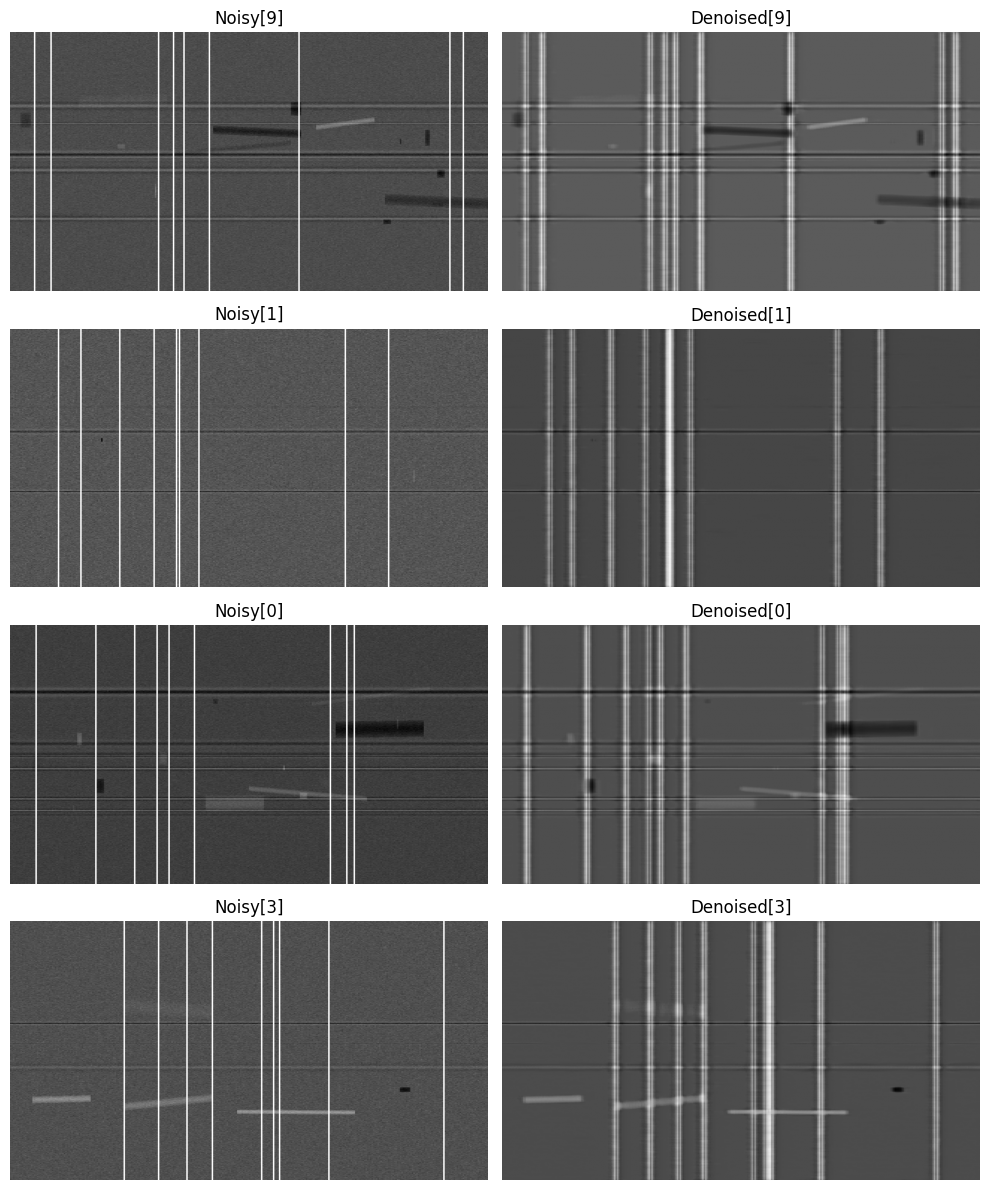

In [6]:
# Visualize a few examples before/after
noisy = np.load(noisy_test_path)
denoised = np.load(denoised_path)
show_samples(noisy, denoised, n=4)